In [69]:
from gravhydro import Simulation
from galpy.potential import NFWPotential
from galpy.actionAngle import actionAngleStaeckel
from scipy.interpolate import interp1d
from galpy.orbit import Orbit
from galpy.df import dehnendf
from astropy import units as u
from astropy import constants as const
import numpy as np
import time
from pynbody.analysis.profile import Profile
import matplotlib.pyplot as plt

import numpy as np
from scipy.differentiate import derivative
from scipy.interpolate import interp1d
from scipy import special, integrate

In [70]:
import scipy
scipy.__version__

'1.15.2'

# Set up ICs

In [ ]:
# For a circular orbit, the velocity should satisfy v = sqrt(G*M/r)
# where M is the central mass, r is the orbital radius, G = 1
G = 1.0
M_central = 1000.0
r = 1.0  # orbital radius

# Circular orbital velocity
v_circular = np.sqrt(G * M_central / r)

q = np.array([[0.0, 0.0, 0.0], [r, 0.0, 0.0]])
masses = np.array([M_central, 0.001])
p = np.array([[0.0, 0.0, 0.0], [0.0, v_circular*masses[1], 0.0]])  # velocity perpendicular to radius


In [86]:
np.gradient

<function gradient at 0x11249b170>

from gravhopper

In [137]:
# from scipy.interpolate import interp1d
# from scipy import special
# # from scipy.misc import derivative
# import numpy as np
# import astropy.units as u
# import astropy.constants as const

def expdisk(sigma0=None, Rd=None, z0=None, sigmaR_Rd=None, external_rotcurve=None, N=None,
            center_pos=None, center_vel=None, force_origin=True, seed=None):
    """
    Generates initial conditions of an exponential disk with a sech^2 vertical distribution.
    """
    rng = np.random.default_rng(seed)

    Rd_kpc = Rd.to(u.kpc).value
    totmass = (np.pi * Rd**2 * sigma0).to(u.Msun)

    # Cylindrical radius transformation to give an exponential
    Rax = np.arange(0.001*Rd_kpc, 10*Rd_kpc, 0.01*Rd_kpc)
    R_cumprob = Rd_kpc**2 - Rd_kpc*np.exp(-Rax/Rd_kpc)*(Rax+Rd_kpc)
    R_cumprob /= R_cumprob[-1]
    probtransform = interp1d(R_cumprob, Rax)
    R_xi = rng.uniform(0.0, 1.0, size=N)
    R = probtransform(R_xi) * u.kpc

    # Random azimuth
    phi = rng.uniform(0.0, 2.0*np.pi, size=N)
    x = R * np.cos(phi)
    y = R * np.sin(phi)

    # z from uniform random deviate, avoid arctanh(1)
    z_xi = rng.uniform(0, 1-1e-10, size=N)
    z = 2 * z0 * np.arctanh(z_xi)
    z *= (2 * (rng.uniform(0, 1, size=N) < 0.5)) - 1

    # Velocity dispersions
    def om2(rad):
        y_R = rad/(2.*Rd_kpc)
        omega2 = np.pi * const.G * sigma0 / Rd * (special.iv(0,y_R)*special.kv(0,y_R) -
                                                  special.iv(1,y_R)*special.kv(1,y_R))
        if external_rotcurve is not None:
            omega_halo = external_rotcurve(rad*u.kpc)*(u.km / u.s) / (rad*u.kpc)
            omega2 += omega_halo**2
        return omega2.to(u.km**2/u.s**2/u.kpc**2).value

    R_vals = R.to(u.kpc)
    Omega2 = om2(R_vals)
    # Vectorize derivative calculation
    kappa2 = np.zeros_like(Omega2)
    dR_vals = np.gradient(om2(R_vals.value))
    for i, r in enumerate(R_vals):
        kappa2[i] = 4.*Omega2[i] + r * dR_vals[i] # units already stripped

    sigma_R = sigmaR_Rd * np.exp(0.25*(1-R/Rd))
    sigma2_phi = sigma_R**2 * 4 * Omega2 / kappa2
    sigma2_z = np.pi * const.G * z0 * sigma0 * 0.5 * np.exp(-R/Rd)
    vphi_mean = (R * np.sqrt(Omega2)).to(u.km/u.s)

    vphi = np.sqrt(sigma2_phi).to(u.km/u.s) * rng.normal(size=N) + vphi_mean
    vR = sigma_R.to(u.km/u.s) * rng.normal(size=N)
    vx = -vphi * np.sin(phi) + vR * np.cos(phi)
    vy = vphi * np.cos(phi) + vR * np.sin(phi)
    vz = np.sqrt(sigma2_z).to(u.km/u.s) * rng.normal(size=N)

    m = np.ones((N)) * (totmass/N)

    # You must define or import force_centers, or remove this if not needed
    # positions, velocities = force_centers(np.vstack((x,y,z)).T, np.vstack((vx,vy,vz)).T,
    #     center_pos=center_pos, center_vel=center_vel, force_origin=force_origin)

    # If you don't have force_centers, just return the arrays:
    positions = np.vstack((x, y, z)).T
    velocities = np.vstack((vx, vy, vz)).T

    outIC = {'pos': positions, 'vel': velocities, 'mass': m}
    return outIC

In [138]:
def force_centers(positions, velocities, center_pos=None, center_vel=None, force_origin=True):
    """Move positions and velocities to have the desired center of mass position and mean velocity.
    
    Parameters
    ----------
    positions : array of Quantities of dimension length
        (Np,3) array of particle positions
    velocities : array of Quantities of dimension velocity
        (Np,3) array of particle velocities
    center_pos : 3 element array-like Quantity, optional
        Force the center of mass of the IC to be at this position
    center_vel : 3 element array-like Quantity, optional
        Force the mean velocity of the IC to have this velocity
    force_origin : bool
        Force the center of mass to be at the origin and the mean velocity to be zero;
        equivalent to setting center_pos=np.array([0,0,0])*u.kpc and
        center_vel=np.array([0,0,0])*u.km/u.s. Default is True unless center_pos and
        center_vel is set. If force_origin is True and only one of center_pos or
        center_vel is set, the other is set to zero.
        
    Returns
    -------
    newpositions : array of Quantities of dimension length
        New shifted positions
    newvelocities : array of Quantities of dimension velocity
        New shifted velocities
    """
    
    newpos = positions
    newvel = velocities
    
    if force_origin:
        if center_pos is None:
            center_pos = np.array([0,0,0])*u.kpc
        if center_vel is None:
            center_vel = np.array([0,0,0])*u.km/u.s
    if center_pos is not None:
        sampled_com = np.mean(positions, axis=0)
        dpos = center_pos - sampled_com
        newpos += dpos
    if center_vel is not None:
        sampled_cov = np.mean(velocities, axis=0)
        dvel = center_vel - sampled_cov
        newvel += dvel 

    return (newpos, newvel)

In [139]:
# def expdisk(sigma0=None, Rd=None, z0=None, sigmaR_Rd=None, external_rotcurve=None, N=None, \
#         center_pos=None, center_vel=None, force_origin=True, seed=None):
#         """Generates initial conditions of an exponential disk with a sech^2 vertical distribution that is
#         in (very) approximate equilibrium: rho(R,z) = (sigma0 / 2 z0) exp(-R/Rd) sech^2(z/z0)
        
#         Parameters
#         ----------
#         sigma0 : astropy Quantity with dimensions of surface density
#             Central surface density
#         Rd : astropy Quantity with dimensions of length
#             Radial exponential scale length
#         z0 : astropy Quantity with dimensions of length
#             Vertical scale height
#         sigmaR_Rd : astropy Quantity with dimensions of velocity
#             Radial velocity dispersion at R=Rd
#         external_rotcurve : function or None
#             Function that returns the circular velocity of any external potential that contributes
#             to the rotation curve aside from the disk itself. The function should accept input
#             as an astropy Quantity of dimension length, and should return an astropy Quantity of
#             dimension velocity.
#         N : int
#             Number of particles
#         center_pos : 3 element array-like Quantity, optional
#             Force the center of mass of the IC to be at this position
#         center_vel : 3 element array-like Quantity, optional
#             Force the mean velocity of the IC to have this velocity
#         force_origin : bool
#             Force the center of mass to be at the origin and the mean velocity to be zero;
#             equivalent to setting center_pos=[0,0,0]*u.kpc and
#             center_vel=[0,0,0]*u.km/u.s. Default is True unless center_pos and
#             center_vel is set. If force_origin is True and only one of center_pos or
#             center_vel is set, the other is set to zero.
#         seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator}, optional
#             Seed to initialize random number generator to enable repeatable ICs.
            
#         Returns
#         -------
#         IC : dict
#            Properties of new particles to add, which sample the given distribution function. Contains
#            the following key/value pairs:
           
#            * **pos:** an array of positions
#            * **vel:** an array of velocities
#            * **mass:** an array of masses
           
#            Each are astropy Quantities, with shape (Np,3).
           
#         Example
#         -------
#         To create an exponential disk that is in a background logarithmic halo potential that
#         generates a flat rotation curve of 200 km/s::
        
#             particles = IC.expdisk(N=10000, sigma0=200*u.Msun/u.pc**2, Rd=2*u.kpc,
#                 z0=0.5*u.kpc, sigmaR_Rd=10*u.km/u.s,
#                 external_rotcurve=lambda x: 200*u.km/u.s)
                
#         """
                
#         rng = np.random.default_rng(seed)

#         Rd_kpc = Rd.to(u.kpc).value
#         totmass = (np.pi * Rd**2 * sigma0).to(u.Msun)

#         # cylindrical radius transformation to give an exponential
#         Rax = np.arange(0.001*Rd_kpc, 10*Rd_kpc, 0.01*Rd_kpc)
#         R_cumprob = Rd_kpc**2 - Rd_kpc*np.exp(-Rax/Rd_kpc)*(Rax+Rd_kpc)
#         R_cumprob /= R_cumprob[-1]
#         probtransform = interp1d(R_cumprob, Rax)   # reverse interpolation
#         # now get the uniform random deviate and transform it
#         R_xi = rng.uniform(0.0, 1.0, size=N)
#         R = probtransform(R_xi) * u.kpc
#         # use random azimuth
#         phi = rng.uniform(0.0, 2.0*np.pi, size=N)
#         x = R * np.cos(phi)
#         y = R * np.sin(phi)
#         # get z from uniform random deviate
#         z_xi = rng.uniform(0, 1.0, size=N)
#         z = 2 * z0 * np.arctanh(z_xi)
#         z *= (2 * (rng.uniform(0, 1, size=N) < 0.5)) - 1

#         # the velocity dispersions go as:
#         #  sigma_R = sigmaR_Rd * exp(-R/Rd)
#         #  sigma2_phi = sigmaR^2 * kappa^2 / 4 Omega^2
#         #  sigma2_z = pi G Sigma(R) z0 / 2
#         # and the mean azimuthal velocity is
#         #  <vphi> = vc
        

#         def om2(rad):
#             # Input must be in kpc but with units stripped, because it's passed into np.derivative.
#             y_R = rad/(2.*Rd_kpc)
#             # Disk contribution
#             omega2 = np.pi * const.G * sigma0 / Rd * (special.iv(0,y_R)*special.kv(0,y_R) -
#                     special.iv(1,y_R)*special.kv(1,y_R))
#             # Halo contribution                   
#             if external_rotcurve is not None:
#                 omega_halo = external_rotcurve(rad*u.kpc)*(u.km / u.s) / (rad*u.kpc)
#                 omega2 += omega_halo**2
                
#             return omega2

#         Omega2 = om2(R.to(u.kpc).value)
#         kappa2 = 4.*Omega2 + R * np.gradient(om2(R.to(u.kpc).value)) / u.kpc

#         sigma_R = sigmaR_Rd * np.exp(0.25*(1-R/Rd))
#         sigma2_phi = sigma_R**2 * 4 * Omega2 / kappa2
#         sigma2_z = np.pi * const.G * z0 * sigma0 * 0.5 * np.exp(-R/Rd)
#         vphi_mean = (R * np.sqrt(Omega2)).to(u.km/u.s)

#         vphi = np.sqrt(sigma2_phi).to(u.km/u.s) * rng.normal(size=N) + vphi_mean
#         vR = sigma_R.to(u.km/u.s) * rng.normal(size=N)
#         vx = -vphi * np.sin(phi) + vR * np.cos(phi)
#         vy = vphi * np.cos(phi) + vR * np.sin(phi)
#         vz = np.sqrt(sigma2_z).to(u.km/u.s) * rng.normal(size=N)

#         m = np.ones((N)) * (totmass/N)
        
#         # Force COM and/or COV
#         positions, velocities = force_centers(np.vstack((x,y,z)).T, np.vstack((vx,vy,vz)).T, \
#             center_pos=center_pos, center_vel=center_vel, force_origin=force_origin)
        
#         outIC = {'pos':positions, 'vel':velocities, 'mass': m}
#         return outIC




In [140]:
NFWpot = NFWPotential(amp=2e11*u.Msun, a=20*u.kpc)
NFWpot.turn_physical_on()
expdisk_IC = expdisk(N=5000, sigma0=100*u.Msun/u.pc**2, Rd=2*u.kpc, z0=0.2*u.kpc, sigmaR_Rd=20*u.km/u.s,
    external_rotcurve=NFWpot.vcirc)

UnitTypeError: Can only apply 'iv' function to dimensionless quantities

In [128]:
expdisk_IC

{'pos': <Quantity [[-4.51843998,  0.76157329,  0.04678204],
            [-1.77978431,  7.79355789,  0.15273174],
            [ 4.89706382,  0.18029123, -0.73167162],
            ...,
            [ 1.81815896,  2.29560128, -0.1542675 ],
            [-3.46894926, -0.47983148,  0.72784786],
            [-3.05920133, -1.9718692 , -0.39456989]] kpc>,
 'vel': <Quantity [[        nan,         nan, -2.89130206],
            [        nan,         nan,  0.59162018],
            [        nan,         nan,  0.183354  ],
            ...,
            [        nan,         nan, -2.25411711],
            [        nan,         nan, -4.66197145],
            [        nan,         nan, -3.67224777]] km / s>,
 'mass': <Quantity [251327.41228718, 251327.41228718, 251327.41228718, ...,
            251327.41228718, 251327.41228718, 251327.41228718] solMass>}

In [12]:
diskPot = MiyamotoNagaiPotential()
aA = actionAngleStaeckel(pot=diskPot, delta=0.45)
df = quasiisothermaldf(pot=diskPot,hr=3.0*u.kpc, sr=0.2*u.km/u.s, sz=0.1*u.km/u.s, hsr=8.0*u.kpc, hsz=4.0*u.kpc,aA=aA)

In [ ]:
totalMass = 1e5 *u.Msun
plummer = PlummerPotential(amp = totalMass , b=(1*u.pc).to(u.kpc))
df = dehnendf()

n_pts = 1000
masses = np.ones(n_pts) * totalMass/n_pts
sample = Orbit(df.sample(n_pts, returnOrbit=True))
q = np.zeros((n_pts, 3)) 
v = np.zeros((n_pts, 3)) 
q[:,0] = sample.x()
q[:,1] = sample.y()
q[:,2] = np.zeros_like()sample.z()
v[:,0] = sample.vx()
v[:,1] = sample.vy()
v[:,2] = sample.vz()
v *= u.km / u.s
q *= u.kpc

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.320979e-06
  warnings.warn(

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.107161e-06
  warnings.warn(

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.441416e-07
  warnings.warn(

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.005719e-05
  warnings.warn(

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.595737e-07
  warnings.warn(

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/util/quadpack.py:135: AccuracyWarning: maxiter (50) exceeded. Latest 

AttributeError: linear and planar orbits do not have z()

In [27]:

Orbit(sample).x()

array([ 8.81487770e-01,  1.31647397e-01,  1.23826412e+00,  3.42843246e-01,
        3.64344947e-01,  2.56286241e-02,  1.06823948e+00,  7.67962958e-01,
        3.39383047e-01, -1.48266179e-01, -1.05070670e+00,  5.92204230e-01,
        4.85032173e-01, -1.79035426e-01,  1.77739875e-01, -5.14760398e-01,
        4.35241856e-01, -2.47369079e-01,  6.74444723e-02, -2.93337363e-01,
        5.38852563e-02,  7.68023073e-02, -1.45300987e-01,  3.46853534e-01,
       -3.71168930e-02,  1.13238333e+00,  2.85117571e-02,  8.60878438e-01,
        8.33977188e-02, -5.36367859e-02,  8.61851971e-01,  4.21704891e-01,
       -1.05944455e-01, -7.40728111e-01,  4.52047866e-01,  6.41518810e-01,
        3.96549041e-01, -2.11532718e-01,  7.23647661e-01, -6.32219568e-01,
       -3.46310160e-01, -2.90773243e-01,  3.48932804e-02, -1.46504809e-01,
       -6.15117466e-03,  5.29968323e-01,  3.18400250e-02, -1.26502177e-03,
        3.60575154e-02,  1.17012168e-02,  2.98445122e-02, -4.50384021e-03,
       -7.12358703e-03,  

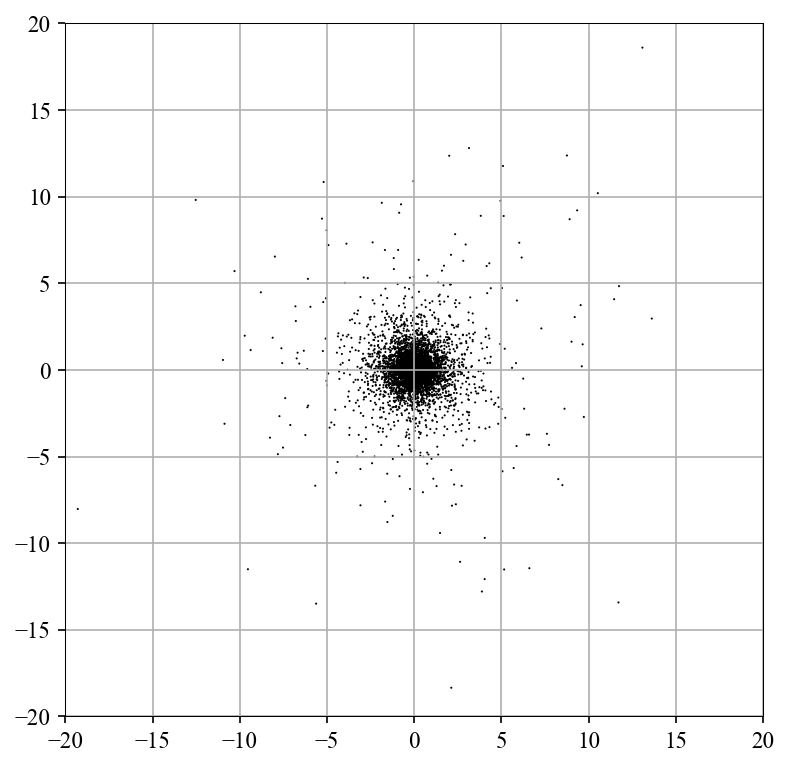

In [5]:
plt.figure(figsize=(6,6), dpi=150)
plt.scatter(q[:,0].to(u.pc).value, q[:,1].to(u.pc).value, s=1)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid(True)

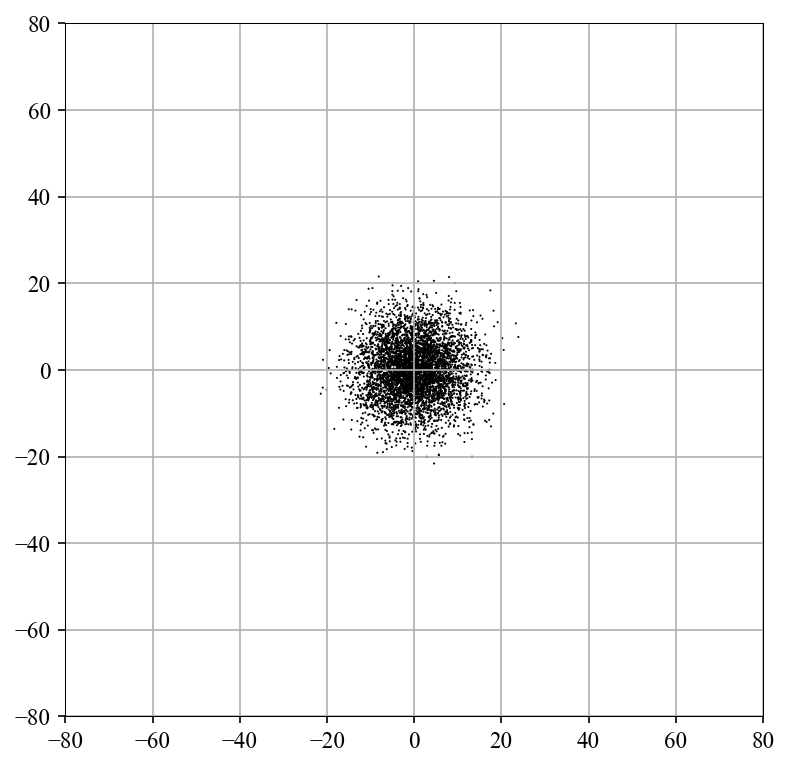

In [ ]:
# plt.figure(figsize=(6,6), dpi=150)
# plt.scatter(v[:,0].to(u.km/u.s).value, v[:,1].to(u.km/u.s).value, s=1)
# plt.grid(True)
# plt.xlim(-80, 80)
# plt.ylim(-80, 80)
# plt.show()

In [7]:
masses

<Quantity [20., 20., 20., ..., 20., 20., 20.] solMass>

In [8]:
dt = 5e3 * u.yr
n_steps = 100
ts = np.linspace(0, n_steps*dt, n_steps)

In [9]:
sim = Simulation()
start = time.time()
sim.run(q.copy(), v.copy(), masses, ts, 
                            gravityMethod='directSummation', use_numba=True)
t_numba = time.time() - start
print(f"Direct (Numba): {t_numba:.3f}s")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Direct (Numba): 0.865s


# Density Profile

In [10]:
sim.pynbodySnap(0)

<SimSnap "<created>" len=5000>

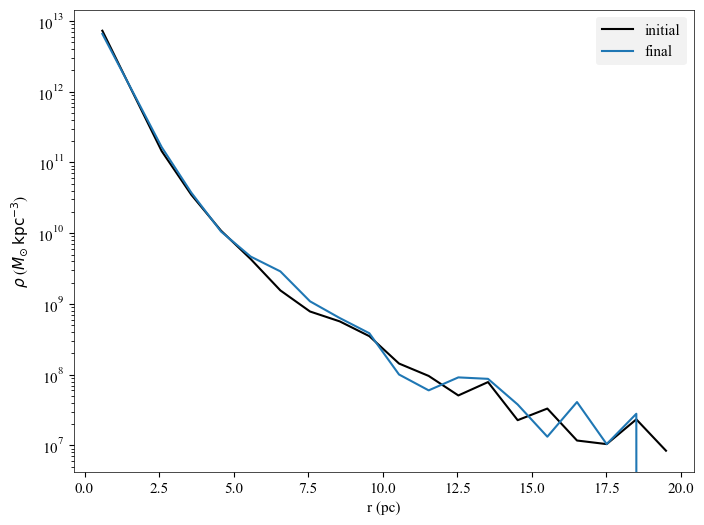

In [14]:
# Plot density profile before and after
s_IC = sim.pynbodySnap(0)
s_final = sim.pynbodySnap(-1)
p_IC = Profile(s_IC, ndim=3, min=0.0001, max=0.02, nbins=20)
p_final = Profile(s_final, ndim=3, min=0.0001, max=0.02, nbins=20)
plt.plot(p_IC['rbins'].in_units('pc'), p_IC['density'], label='initial')
plt.plot(p_final['rbins'].in_units('pc'), p_final['density'], label='final')
plt.yscale('log')
plt.xlabel('r (pc)')
plt.ylabel(f'$\\rho$ (${p_IC["density"].units.latex()}$)')
plt.legend()

In [ ]:
# # Plot density profile before and after
# s_IC = sim.pyn_snap(timestep=0)
# s_final = sim.pyn_snap()
# p_IC = Profile(s_IC, ndim=3, min=0.0001, max=0.02, nbins=20)
# p_final = Profile(s_final, ndim=3, min=0.0001, max=0.02, nbins=20)
# plt.plot(p_IC['rbins'].in_units('pc'), p_IC['density'], label='initial')
# plt.plot(p_final['rbins'].in_units('pc'), p_final['density'], label='final')
# plt.yscale('log')
# plt.xlabel('r (pc)')
# plt.ylabel(f'$\\rho$ (${p_IC["density"].units.latex()}$)')
# plt.legend()

# Animation

In [ ]:
import plotly.graph_objects as go

# Get snapshots at regular intervals
n_frames = 20
frame_indices = np.linspace(0, len(sim.time) - 1, n_frames, dtype=int)

# Sample every nth particle
particle_step = 10

# Determine axis limits from all frames
all_coords = []
for idx in frame_indices:
    #snap = sim.pyn_snap(timestep=idx)
    all_coords.extend(sim.x(idx)[::particle_step].value)
    all_coords.extend(sim.y(idx)[::particle_step].value)
    all_coords.extend(sim.z(idx)[::particle_step].value)
max_range = max(abs(min(all_coords)), abs(max(all_coords))) * 0.05

# Create frames for animation
frames = []
for i, idx in enumerate(frame_indices):
    #snap = sim.pyn_snap(timestep=idx)
    x = sim.x(idx)[::particle_step].value
    y = sim.y(idx)[::particle_step].value
    z = sim.z(idx)[::particle_step].value
    
    frames.append(go.Frame(
        data=[go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=2, color='black', opacity=0.6)
        )],
        name=str(i)
    ))

# Initial data
# snap_init = sim.pyn_snap(timestep=0)
x0 = sim.x(0)[::particle_step].value
y0 = sim.y(0)[::particle_step].value
z0 = sim.z(0)[::particle_step].value

# Create figure
fig = go.Figure(
    data=[go.Scatter3d(
        x=x0, y=y0, z=z0,
        mode='markers',
        marker=dict(size=2, color='black', opacity=0.6)
    )],
    layout=go.Layout(
        title='Plummer Sphere Evolution',
        scene=dict(
            xaxis_title='x (kpc)',
            yaxis_title='y (kpc)',
            zaxis_title='z (kpc)',
            xaxis=dict(range=[-max_range, max_range]),
            yaxis=dict(range=[-max_range, max_range]),
            zaxis=dict(range=[-max_range, max_range]),
            aspectmode='cube'
        ),
        updatemenus=[dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(label='Play',
                     method='animate',
                     args=[None, dict(frame=dict(duration=100, redraw=True),
                                      fromcurrent=True, mode='immediate')]),
                dict(label='Pause',
                     method='animate',
                     args=[[None], dict(frame=dict(duration=0, redraw=False),
                                        mode='immediate')])
            ]
        )],
        sliders=[dict(
            steps=[dict(method='animate',
                        args=[[str(i)], dict(mode='immediate',
                                             frame=dict(duration=100, redraw=True))],
                        label=str(i)) for i in range(len(frames))],
            active=0,
            transition=dict(duration=0),
            currentvalue=dict(prefix='Frame: ')
        )]
    ),
    frames=frames
)

fig.show()